# Convolutional Neural Network for Emotion Recognition

## Imports a usar

In [38]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import torch
from torchvision import datasets, transforms
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

import shutil
from pathlib import Path


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import random


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Carga y Exploración de Datos


In [3]:
dataset_url = "https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions


100%|██████████| 701M/701M [00:02<00:00, 342MB/s] 


In [ ]:
dataset_path = Path("human-face-emotions") / "Data"

filtered_path = Path("human-face-emotions-filtered")

categories = ["Angry", "Fear", "Happy", "Sad", "Suprise"]

### Importante: 
debido a que el dataset original contiene una gran cantidad de imágenes (8000), para facilitar su manejo y reducir el tiempo de entrenamiento, se decidió crear un subconjunto balanceado. Este subconjunto contiene un máximo de 1000 imágenes seleccionadas aleatoriamente por cada categoría.

Esta reducción permite disminuir la complejidad computacional y ahorrar espacio en disco, manteniendo una representación adecuada de cada clase para el entrenamiento del modelo.

In [41]:
def filtrar_dataset_aleatorio(dataset_path, filtered_path, categories, max_imgs=1000):
    if filtered_path.exists():
        shutil.rmtree(filtered_path)
    filtered_path.mkdir(parents=True, exist_ok=True)

    for cat in categories:
        imgs = list((dataset_path / cat).glob('*.jpg')) \
             + list((dataset_path / cat).glob('*.jpeg')) \
             + list((dataset_path / cat).glob('*.png'))

        imgs_sample = random.sample(imgs, min(len(imgs), max_imgs))

        cat_filtered_dir = filtered_path / cat
        cat_filtered_dir.mkdir(exist_ok=True)

        for img in imgs_sample:
            shutil.copy(img, cat_filtered_dir / img.name)

    print("Filtrado completo. Subset creado en:", filtered_path)

filtrar_dataset_aleatorio(dataset_path, filtered_path, categories)


Filtrado completo. Subset creado en: human-face-emotions-filtered


In [42]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=str(filtered_path), transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [43]:
class TransformedSubset:
    def __init__(self, subset: Subset, transform: transforms.Compose):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index: int) -> tuple:
        img, label = self.subset[index]
        img = self.transform(img)
        return img, label
    
    def __len__(self) -> int:
        return len(self.subset)


In [44]:
dataset_path = "human-face-emotions/Data"

full_dataset = datasets.ImageFolder(root=dataset_path)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

np.random.seed(42)

index = np.arange(len(full_dataset))
np.random.shuffle(index)

train_percent = 0.8
test_val_percent = 0.1

train_index = int(train_percent * len(full_dataset))
test_val_index = int((train_percent + test_val_percent) * len(full_dataset))

dataset_train = TransformedSubset(Subset(full_dataset, index[:train_index]), transform_train)
dataset_val = TransformedSubset(Subset(full_dataset, index[train_index:test_val_index]), transform_test_val)
dataset_test = TransformedSubset(Subset(full_dataset, index[test_val_index:]), transform_test_val)


### Configuración de DataLoaders con PyTorch

Aquí establecemos cómo se dividirán y cargarán las imágenes etiquetadas para entrenar y validar nuestro modelo. Ajustamos la cantidad de ejemplos por lote y decidimos si barajar o no los datos según la fase (entrenamiento o evaluación).

Este paso es crucial para asegurar que el modelo vea diversidad durante el entrenamiento y resultados fiables en validación y prueba.


In [45]:

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


## Visualizamos las imagenes del dataset


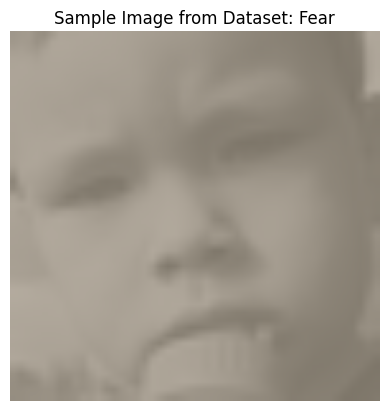

In [46]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

idx = random.randint(0, images.shape[0] - 1)

image = images[idx].numpy()
image = np.transpose(image, (1, 2, 0))  

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean 
image = np.clip(image, 0, 1)

plt.title(f"Sample Image from Dataset: {full_dataset.classes[labels[idx].item()]}")
plt.imshow(image)
plt.axis('off')
plt.show()


## Estructura de la Red Neuronal Convolucional

In [47]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Ajusta las dimensiones del FC de entrada: 256 * 14 * 14 para imagen 224x224 con 4 pooling 2x2
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(256, 5)  
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

## Prueba de la Red Neuronal Convolucional

In [48]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 5
early_stopping_criteria = 15
early_stopping_counter = 0
best_val_loss = float('inf')

total_val_loss = []
total_train_loss = []
total_val_accuracy = []
total_training_accuracy = []

for epoch in range(epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    total_train_loss.append(train_loss)
    train_accuracy = 100 * train_correct / train_total
    total_training_accuracy.append(train_accuracy)

    # Validación
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    total_val_loss.append(val_loss)
    val_accuracy = 100 * val_correct / val_total
    total_val_accuracy.append(val_accuracy)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_criteria:
        print(f'Early stopping at epoch {epoch+1}')
        break

    print(f'Epoch {epoch+1}/{epochs} - '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, '
          f'Val Acc: {val_accuracy:.2f}%')


Epoch 1/5 - Train Loss: 1.6207, Train Acc: 30.75%, Val Loss: 1.5619, Val Acc: 31.35%
Epoch 2/5 - Train Loss: 1.5607, Train Acc: 31.50%, Val Loss: 1.5358, Val Acc: 32.37%


In [32]:
model.eval()
test_correct = 0
test_total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Accuracy of the model on test images: {test_accuracy:.2f}%')


Accuracy of the model on test images: 31.95%


## Graphics

### Confusion Matrix

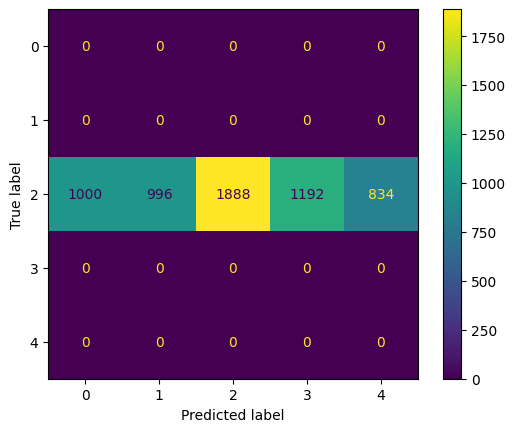

In [33]:
cm = confusion_matrix(y_pred, y_true)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## Loss And Accuraccy Graphics

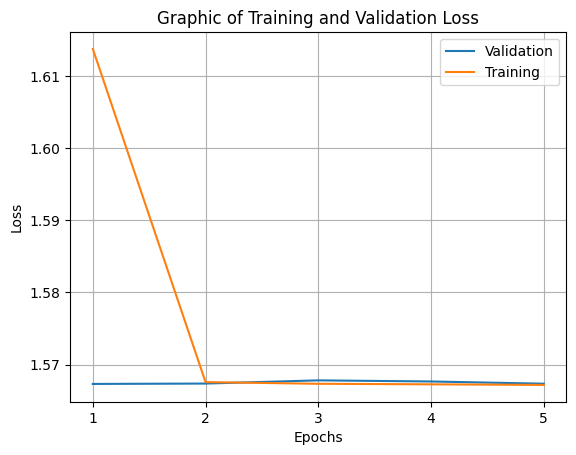

In [34]:
plt.plot(range(1, epochs+1), total_val_loss, label='Validation')
plt.plot(range(1, epochs+1), total_train_loss, label='Training')
plt.xticks(range(1, epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Graphic of Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

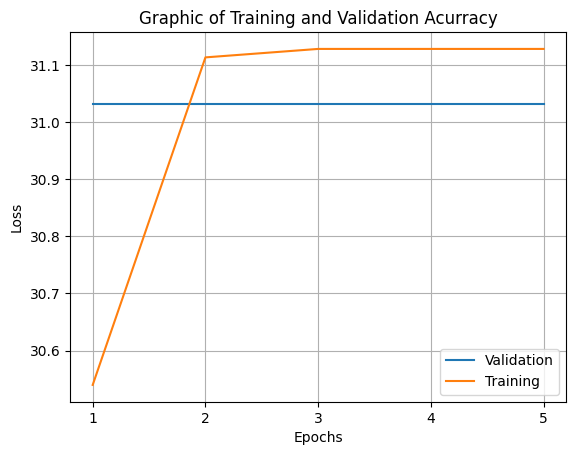

In [35]:
plt.plot(range(1, epochs+1), total_val_accuracy, label='Validation')
plt.plot(range(1, epochs+1), total_training_accuracy, label='Training')
plt.xticks(range(1, epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Graphic of Training and Validation Acurracy')
plt.legend()
plt.grid()
plt.show()